In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import empyrical
%matplotlib inline

In [69]:
assets_fname = u'../data/资产.xlsx'

In [70]:
names = [u'翁兆宇', u'张炀', u'曹越奇', u'潘弘林']

In [71]:
df = pd.read_excel(assets_fname, index_col=0)

In [72]:
df.tail()

,000906.SH,CBA00101.CS,SPGSCITR.SPI,H11025.CSI
2018-03-09,4461.4516,175.6050,2561.87,1467.2690
2018-03-12,4493.0476,175.6889,2545.11,1467.7733
2018-03-13,4455.9859,175.6544,2539.33,1467.9449
2018-03-14,4429.5475,175.6661,2545.42,1468.1145
2018-03-15,4446.2382,175.6991,2543.86,1468.2844


In [73]:
ret_df = df.pct_change().dropna()

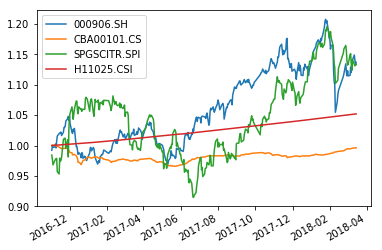

In [74]:
(1+ret_df).cumprod().plot()

In [75]:
est = pd.read_excel(assets_fname, index_col=0, sheetname='Sheet2')

In [76]:
est = est / 100

In [77]:
est['avg'] = est.mean(axis=1)

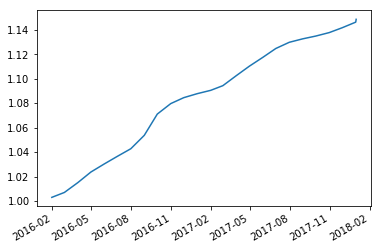

In [78]:
(1+est['avg']).cumprod().plot()

# 计算波动率

In [79]:
vol_df = ret_df.resample('BM').last().rolling(window=12).apply(lambda x: empyrical.annual_volatility(x, period='monthly'))

In [80]:
vol_df.dropna().tail()

,000906.SH,CBA00101.CS,SPGSCITR.SPI,H11025.CSI
2017-11-30,0.015889,0.002105,0.040096,0.000283
2017-12-29,0.016039,0.001733,0.039833,0.000280
2018-01-31,0.015926,0.001726,0.039954,0.000277
2018-02-28,0.017244,0.001656,0.044095,0.000274
2018-03-30,0.016871,0.001648,0.044181,0.000273


In [81]:
est_vol = est['avg'].rolling(window=12).apply(lambda x: empyrical.annual_volatility(x, period='monthly'))

In [82]:
est_vol.tail()

2017-09-30    0.007508
2017-10-31    0.006972
2017-11-30    0.007024
2017-12-31    0.006894
2018-01-01    0.007058
Name: avg, dtype: float64

In [83]:
vol_df['estate'] = est_vol

In [84]:
vol_df

,000906.SH,CBA00101.CS,SPGSCITR.SPI,H11025.CSI,estate
2016-11-30,NaN,NaN,NaN,NaN,NaN
2016-12-30,NaN,NaN,NaN,NaN,NaN
2017-01-31,NaN,NaN,NaN,NaN,0.013232
2017-02-28,NaN,NaN,NaN,NaN,0.013365
2017-03-31,NaN,NaN,NaN,NaN,0.013331
2017-04-28,NaN,NaN,NaN,NaN,NaN
2017-05-31,NaN,NaN,NaN,NaN,0.013221
2017-06-30,NaN,NaN,NaN,NaN,0.013198
2017-07-31,NaN,NaN,NaN,NaN,0.013385
2017-08-31,NaN,NaN,NaN,NaN,0.013303


In [85]:
vol_df = vol_df.fillna(method='ffill')

In [86]:
vol_df.tail()

,000906.SH,CBA00101.CS,SPGSCITR.SPI,H11025.CSI,estate
2017-11-30,0.015889,0.002105,0.040096,0.000283,0.007024
2017-12-29,0.016039,0.001733,0.039833,0.000280,0.007024
2018-01-31,0.015926,0.001726,0.039954,0.000277,0.007024
2018-02-28,0.017244,0.001656,0.044095,0.000274,0.007024
2018-03-30,0.016871,0.001648,0.044181,0.000273,0.007024


# 根据打分计算风险权重、资产权重

In [87]:
for name in names:
    print name
    fname = u'../data/%s-打分.xlsx'%(name)
    score = pd.read_excel(fname, index_col=0)
    print score
#     current = vol_df[vol_df.index == score.index[-1]]
#     current.loc[:, 'Real Estate'] = est_vol[-1]
    money_per = score['Cash']
    score['Cash'] = 0
    weight_df = pd.DataFrame(index=score.index, columns=score.columns)
    for date in score.index:
        last_vol = vol_df[vol_df.index <= date].iloc[-1]
        weight = score.loc[date] / last_vol.values
        weight_df.loc[date] = weight
#     print weight_df
    weight_df['Cash'] = weight_df.sum(axis=1) * money_per / (1 - money_per)
    weight_df = weight_df.div(weight_df.sum(axis=1), axis='index')
    print weight_df
    fname = u'../data/%s-权重.xlsx'%(name)
    weight_df.to_excel(fname)
#     score = score[['Equity', 'Bond', 'Commodity', 'Cash', 'Real Estate']]
#     weight = score.iloc[-1].values / current
#     weight = weight.div(weight.sum(axis=1), axis='index')
#     fname = u'../data/%s-权重.xlsx'%(name)
#     weight_df = pd.read_excel(fname)
#     if weight_df.index[-1] == weight.index[-1]:
#         continue
#     print weight_df
#     print weight
#     weight.columns = weight_df.columns
#     print weight
#     weight_df = weight_df.append(weight)
#     print weight_df
#     weight_df.to_excel(fname)

翁兆宇
            Equity  Bond  Commodity  Cash  Real Estate
2017-11-13     1.8   1.6        3.4     0          1.0
2017-12-25     2.4   1.8        3.0     0          1.2
2018-01-29     3.2   0.6        3.6     0          1.6
              Equity      Bond  Commodity Cash Real Estate
2017-11-13  0.167432   0.59833  0.0676533    0    0.166585
2017-12-25  0.120661  0.683108  0.0597673    0    0.136464
2018-01-29  0.230963  0.400738    0.10462    0    0.263678
张炀
            Equity  Bond  Commodity  Cash  Real Estate
2017-11-13     3.4   1.6        2.8   0.0          0.2
2017-12-25     3.0   1.4        3.2   0.4          0.0
2018-01-29     3.4   2.4        2.8   0.2          0.4
               Equity      Bond  Commodity Cash Real Estate
2017-11-13   0.315119  0.596171  0.0555134    0   0.0331968
2017-12-25   0.121327   0.42739  0.0512829  0.4           0
2018-01-29  0.0983737  0.642581  0.0326195  0.2   0.0264254
曹越奇
            Equity  Bond  Commodity  Cash  Real Estate
2017-11-13     2.6

# 计算每人收益率

In [88]:
fname = u'../data/%s-权重.xlsx'%(names[1])
weight_df = pd.read_excel(fname, index_col=0)

In [89]:
weight_df

,Equity,Bond,Commodity,Cash,Real Estate
2017-11-13,0.315119,0.596171,0.055513,0.0,0.033197
2017-12-25,0.121327,0.427390,0.051283,0.4,0.000000
2018-01-29,0.098374,0.642581,0.032619,0.2,0.026425


In [90]:
ret_df = ret_df[ret_df.index >= weight_df.index[0]]
ret_df['Real Estate'] = est[est.index >= weight_df.index[0]]['avg']
ret_df = ret_df.fillna(0)
ret_df.columns = weight_df.columns

In [91]:
# prev_weight = weight_df.iloc[0]
# daily_weight.iloc[0] = prev_weight
daily_weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
for date in ret_df.index:
    if date in weight_df.index:
        daily_weight.loc[date] = weight_df.loc[date]
    else:
        daily_weight.loc[date] = (1 + ret_df.loc[date]) * prev_weight
#     print (1 + ret_df.loc[date]), prev_weight, (1 + ret_df.loc[date]) * prev_weight, daily_weight.loc[date]
    prev_weight = daily_weight.loc[date]
daily_weight = daily_weight.div(daily_weight.sum(axis=1), axis='index')

In [92]:
daily_weight

,Equity,Bond,Commodity,Cash,Real Estate
2017-11-13,0.315119,0.596171,0.0555134,0,0.0331968
2017-11-14,0.313898,0.597947,0.0548416,0,0.0333138
2017-11-15,0.312274,0.599502,0.0548253,0,0.0333991
2017-11-16,0.313642,0.598559,0.0544694,0,0.0333296
2017-11-17,0.312232,0.599044,0.05537,0,0.0333536
2017-11-20,0.313844,0.597921,0.0549438,0,0.0332912
2017-11-21,0.316905,0.594997,0.0549487,0,0.0331489
2017-11-22,0.317332,0.593978,0.055531,0,0.0331588
2017-11-23,0.31112,0.599369,0.0560453,0,0.0334659
2017-11-24,0.310998,0.599276,0.0562893,0,0.0334369


In [93]:
dic = {}
ret_df['Real Estate'] = est[est.index >= weight_df.index[0]]['avg']
ret_df = ret_df.fillna(0)
ret_df = ret_df[ret_df.index >= weight_df.index[0]]
ret_df.columns = weight_df.columns
for name in names:
    print name
    fname = u'../data/%s-权重.xlsx'%(name)
    weight_df = pd.read_excel(fname, index_col=0)
    
    daily_weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
    for date in ret_df.index:
        if date in weight_df.index:
            daily_weight.loc[date] = weight_df.loc[date]
        else:
            daily_weight.loc[date] = (1 + ret_df.loc[date]) * prev_weight
        prev_weight = daily_weight.loc[date]
    daily_weight = daily_weight.div(daily_weight.sum(axis=1), axis='index')
    
    daily_weight.to_excel(u'../data/%s-每日权重.xlsx'%(name))
    dic[name] = (daily_weight * ret_df).sum(axis=1)
return_df = pd.DataFrame(dic)

翁兆宇
张炀
曹越奇
潘弘林


# 综合打分

In [94]:
weight_dic = {}
for name in names:
    weight_dic[name] = pd.read_excel(u'../data/%s-每日权重.xlsx'%(name))

In [95]:
weight_weight = 2.5 * weight_dic[u'翁兆宇'] + \
                1.0 * weight_dic[u'张炀'] + \
                1.0 * weight_dic[u'曹越奇'] + \
                1.0 * weight_dic[u'潘弘林']

In [96]:
weight_weight = weight_weight / 5.5

In [97]:
weight_weight.to_excel(u'../data/综合打分.xlsx')

In [98]:
return_df[u'综合'] = (ret_df * weight_weight).sum(axis=1)

In [99]:
return_df

,张炀,曹越奇,潘弘林,翁兆宇,综合
2017-11-13,0.000465,-0.000126,0.000030,-0.000165,-0.000008
2017-11-14,-0.003494,-0.002051,-0.002700,-0.002595,-0.002679
2017-11-15,-0.002539,-0.001308,-0.001843,-0.001441,-0.001690
2017-11-16,0.002093,0.001199,0.001657,0.001088,0.001394
2017-11-17,-0.000698,-0.000235,-0.000478,0.000256,-0.000140
2017-11-20,0.001889,0.000935,0.001376,0.000782,0.001119
2017-11-21,0.004337,0.002078,0.003013,0.002298,0.002759
2017-11-22,-0.000288,-0.000676,-0.000723,-0.000324,-0.000454
2017-11-23,-0.009001,-0.004673,-0.006615,-0.004820,-0.005880
2017-11-24,0.000867,0.000688,0.000820,0.000862,0.000824


In [100]:
(1+return_df).cumprod().to_excel(u'../data/净值.xlsx')

In [101]:
return_df

,张炀,曹越奇,潘弘林,翁兆宇,综合
2017-11-13,0.000465,-0.000126,0.000030,-0.000165,-0.000008
2017-11-14,-0.003494,-0.002051,-0.002700,-0.002595,-0.002679
2017-11-15,-0.002539,-0.001308,-0.001843,-0.001441,-0.001690
2017-11-16,0.002093,0.001199,0.001657,0.001088,0.001394
2017-11-17,-0.000698,-0.000235,-0.000478,0.000256,-0.000140
2017-11-20,0.001889,0.000935,0.001376,0.000782,0.001119
2017-11-21,0.004337,0.002078,0.003013,0.002298,0.002759
2017-11-22,-0.000288,-0.000676,-0.000723,-0.000324,-0.000454
2017-11-23,-0.009001,-0.004673,-0.006615,-0.004820,-0.005880
2017-11-24,0.000867,0.000688,0.000820,0.000862,0.000824
